# Business Problem

ABC Bank is facing challenges in detecting credit card fraud due to their high volume of transactions. Their current system struggles with identifying fraud, leading to financial losses and customer dissatisfaction. To address these issues, the bank aims to develop a machine learning model with the goal of minimizing financial losses, improving customer trust, and enhancing operational efficiency by reducing manual transaction reviews.

# Data Summary

This dataset, Credit Card Transaction Records Dataset, is from Kaggle. It contains over 1.3 million records of credit card transactions, including details about transaction times, amounts, and personal and merchant information. 

For the purposes of running analysis and models efficiently, the data set was trimmed to 50,000 rows. Out of the 50,000 transactions, 6,363 transactions are fraudulent.

# Project Summary

In this project, I focused on developing a machine learning pipeline to detect credit card fraud using an imbalanced dataset. 

To address the class imbalance, I used various resampling techniques, including oversampling, SMOTE, Borderline SMOTE, KMeans SMOTE, ADASYN, SMOTE Tomek, and SMOTE ENN. These methods were used to create a balanced training set, improving the ability to detect fraud.

For the classification models, I used the following algorithms, Logistic Regression, Decision Tree Classifier, K-Nearest Neighbors, Bagging Classifier, Random Forest, and KMeans. These models provided a baseline performance and were evaluated to determine their effectiveness in fraud detection.

Additionally, I implemented boosting models to improve the results of the best basline model. I used Gradient Boosting Classifier, XGBoost (XGBClassifier), and LightGBM (LGBMClassifier). The best base model was the Random Forest model that used Adaptive Synthetic Re-sampling(ADASYN). This model boosted using LightGBM achieved the highest PR-AUC score of 0.999435. 

The PR-AUC score tells us that the model is effective at identifying the positive class (credit card fraud) with a good balance between precision (few false positives) and recall (few false negatives). This means the model is strong at correctly detecting actual fraud cases while minimizing false alarms. 

This project demonstrates the effectiveness of using resampling techniques and boosting models to tackle the challenge of detecting fraud in an imbalanced dataset, offering a solution for real-world fraud detection scenarios.

# Import Packages and Data

In [4]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from geopy.distance import great_circle

from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc, make_scorer
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, KMeansSMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.cluster import KMeans

from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [5]:
import sys
import os

# Add the src directory to the Python path
sys.path.append(os.path.abspath('../src'))

# Import all classes from classes.py
from classes import *

In [6]:
cc_df = pd.read_csv("../data/credit_card_purchases_sampled.csv")

In [7]:
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             50000 non-null  int64  
 1   trans_date_trans_time  50000 non-null  object 
 2   cc_num                 50000 non-null  int64  
 3   merchant               50000 non-null  object 
 4   category               50000 non-null  object 
 5   amt                    50000 non-null  float64
 6   first                  50000 non-null  object 
 7   last                   50000 non-null  object 
 8   gender                 50000 non-null  object 
 9   street                 50000 non-null  object 
 10  city                   50000 non-null  object 
 11  state                  50000 non-null  object 
 12  zip                    50000 non-null  int64  
 13  lat                    50000 non-null  float64
 14  long                   50000 non-null  float64
 15  ci

In [8]:
# Drop included index col
cc_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [9]:
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   trans_date_trans_time  50000 non-null  object 
 1   cc_num                 50000 non-null  int64  
 2   merchant               50000 non-null  object 
 3   category               50000 non-null  object 
 4   amt                    50000 non-null  float64
 5   first                  50000 non-null  object 
 6   last                   50000 non-null  object 
 7   gender                 50000 non-null  object 
 8   street                 50000 non-null  object 
 9   city                   50000 non-null  object 
 10  state                  50000 non-null  object 
 11  zip                    50000 non-null  int64  
 12  lat                    50000 non-null  float64
 13  long                   50000 non-null  float64
 14  city_pop               50000 non-null  int64  
 15  jo

In [10]:
cc_df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,2020-06-03 12:43:29,581293083266,fraud_Reilly LLC,home,77.90,William,Thomas,M,39227 Mcpherson Shoals,Lahoma,...,-98.0727,1078,Podiatrist,1989-10-06,f3d6477a2e1bb93f4c1b18adf2a607d1,1370263409,36.566036,-97.237692,0,74644.0
1,2020-04-18 19:57:14,340953839692349,fraud_Hamill-D'Amore,health_fitness,47.78,Tyler,Wright,M,615 Clarke Spring Apt. 172,Warren,...,-82.9832,134056,"Doctor, hospital",1980-05-18,0fbb710e4a8d253580751528c7a2cd92,1366315034,42.837893,-83.228559,0,48370.0
2,2019-01-14 22:23:54,3595192916105588,"fraud_Kerluke, Considine and Macejkovic",misc_net,690.81,Dustin,Roberts,M,3283 James Station,Fayetteville,...,-79.0080,238602,"Scientist, research (maths)",1993-05-14,cc0ce65bebf95fd2b2f76b3f8d2c15f7,1326579834,35.439158,-78.609636,1,27521.0
3,2019-08-02 09:31:48,4390966588600992777,fraud_Torp-Labadie,gas_transport,65.85,Kyle,Simmons,M,8149 Harris Divide,Oklahoma City,...,-97.5583,640470,Advertising copywriter,1966-06-24,d5b4400db9755821f60fa0bec602b2d2,1343899908,36.531040,-97.737859,0,74640.0
4,2019-01-14 16:03:53,36485887555770,"fraud_Reichert, Shanahan and Hayes",shopping_net,67.11,Michael,Gross,M,230 Ryan Tunnel Apt. 025,Fulton,...,-82.8342,267,Facilities manager,2005-01-29,6270f5ee1b11d2354d6828508860f1ed,1326557033,41.189226,-81.864998,0,44280.0


In [15]:
cc_df['category'].unique().tolist()

['home',
 'health_fitness',
 'misc_net',
 'gas_transport',
 'shopping_net',
 'personal_care',
 'misc_pos',
 'kids_pets',
 'grocery_pos',
 'shopping_pos',
 'travel',
 'grocery_net',
 'food_dining',
 'entertainment']

# Exploratory Data Analysis and Cleaning

## Column Re-labeling

In [8]:
# Cast cc_num to string
cc_df['cc_num'] = cc_df['cc_num'].astype(str)

# Cast trans_date_trans_time to datetime
cc_df['trans_date_trans_time'] = pd.to_datetime(cc_df['trans_date_trans_time'])
cc_df['dob'] = pd.to_datetime(cc_df['dob'])

# Rename column
cc_df.rename(columns={'trans_date_trans_time' : 'timestamp'}, inplace=True)

# Drop column
cc_df.drop(['unix_time'], axis=1, inplace=True)

## Missingness

The only column with missing values is 'merch_zipcode'. Lets investigate this column to see the effect dropping the columns would have. 

In [9]:
# Calculate the total number of rows
total_rows = cc_df.shape[0]

# Calculate the number of non-null merch_zipcode values
non_null_merch_zipcode = cc_df['merch_zipcode'].notnull().sum()

# Calculate the number of missing merch_zipcode values
missing_merch_zipcode = total_rows - non_null_merch_zipcode

# Calculate the percentage of missing values
percentage_missing = (missing_merch_zipcode / total_rows) * 100

# Display the percentage of missing values
print(f"Percentage of merch_zipcode values that are missing: {percentage_missing:.2f}%")

Percentage of merch_zipcode values that are missing: 15.07%


Given that ~15% of the merchants zipcode are missing, dropping this many rows is difficult to do. But, there will still be 42,000 transactions. 

When the model is being run, if the merchant zipcode is not an important feature, this decision will be revisited. 

In [10]:
# Drop NaNs
cc_df.dropna(subset=['merch_zipcode'], inplace=True)

# Cast zip to string
cc_df['merch_zipcode'] = cc_df['merch_zipcode'].astype(str)

## Numerical Columns

In [11]:
cc_df.describe()

,timestamp,amt,zip,lat,long,city_pop,dob,merch_lat,merch_long,is_fraud
count,42464,42464.000000,42464.000000,42464.000000,42464.000000,4.246400e+04,42464,42464.000000,42464.000000,42464.000000
mean,2019-10-02 15:50:25.013799936,136.132126,46575.423370,38.595645,-88.780103,8.737273e+04,1973-03-04 11:51:47.611152992,38.601349,-88.784797,0.149845
min,2019-01-01 00:17:40,1.000000,1257.000000,20.027100,-155.488000,2.300000e+01,1924-10-30 00:00:00,19.399206,-156.118071,0.000000
25%,2019-06-02 16:48:16.750000128,11.947500,24070.000000,35.058300,-95.350900,8.040000e+02,1961-12-05 00:00:00,35.175649,-95.421944,0.000000
50%,2019-10-02 03:56:53,53.620000,45801.000000,39.371600,-86.545700,2.501000e+03,1974-12-24 00:00:00,39.369549,-86.605711,0.000000
75%,2020-01-30 21:56:41.750000128,106.400000,68463.000000,41.603000,-79.808900,1.886275e+04,1986-11-24 00:00:00,41.704286,-79.766672,0.000000
max,2020-06-21 11:59:45,9999.390000,99323.000000,48.887800,-67.950300,2.906700e+06,2005-01-29 00:00:00,49.116921,-67.027467,1.000000
std,NaN,256.452379,25996.838552,4.551974,12.375770,2.979376e+05,NaN,4.555899,12.372878,0.356923


### Amount

Lets attempt to see if there are any patterns that revolve around the amount spent by the customer and if that transaction was fraud. 

My assumption would be that purchases under $100 and larger purchases have a higher tendency to be fraud. A bad actor would first test out the stolen credit card information to ensure it processes with smaller purchases before attempting a larger purchase. 

We can view these delineations in the columns by bucketing the amount and calculating the percentage of fraud in each category. 

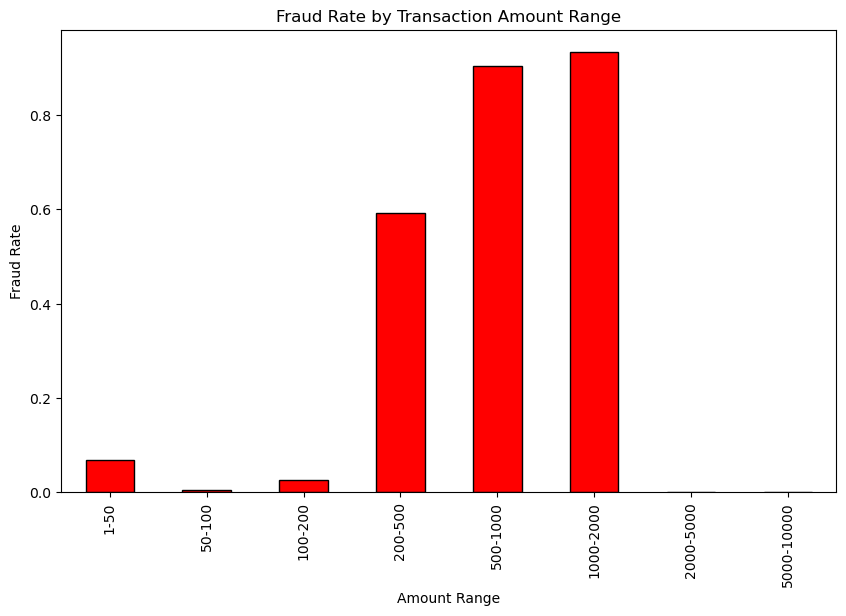

In [12]:
# Define bins for transaction amounts
bins = [1, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
labels = ['1-50', '50-100', '100-200', '200-500', '500-1000', '1000-2000', '2000-5000', '5000-10000']

# Add a new column to classify amounts into ranges
cc_df['amt_range'] = pd.cut(cc_df['amt'], bins=bins, labels=labels)

# Group by amount range and calculate the fraud rate
fraud_rate_by_range = cc_df.groupby('amt_range')['is_fraud'].mean()

# Plot the fraud rate by amount range
plt.figure(figsize=(10, 6))
fraud_rate_by_range.plot(kind='bar', color='red', edgecolor='black')
plt.title('Fraud Rate by Transaction Amount Range')
plt.xlabel('Amount Range')
plt.ylabel('Fraud Rate')
plt.show()

Given that the majority of the fraudulent transactions occur inside of the 200-2000 amount, lets take a deeper look at these buckets. 

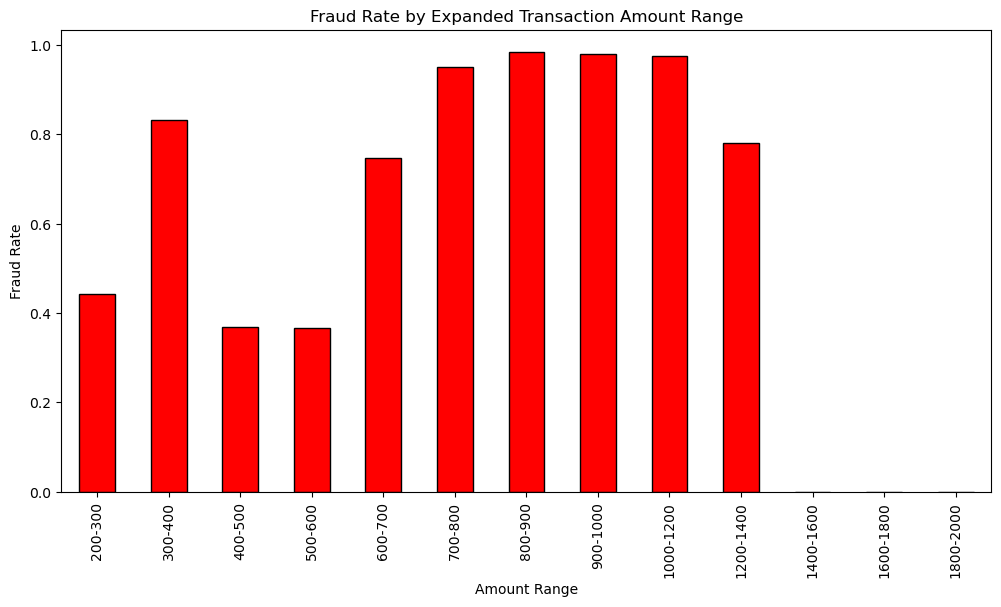

In [13]:
# Define finer bins within the ranges
expanded_bins = [200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000]
expanded_labels = ['200-300', '300-400', '400-500', '500-600', '600-700', '700-800', '800-900', '900-1000', '1000-1200', '1200-1400', '1400-1600', '1600-1800', '1800-2000']

# Add a new column to classify amounts into the expanded ranges
cc_df['expanded_amt_range'] = pd.cut(cc_df['amt'], bins=expanded_bins, labels=expanded_labels)

# Group by the new range column and calculate the fraud rate
expanded_fraud_rate_by_range = cc_df.groupby('expanded_amt_range')['is_fraud'].mean()

# Plot the expanded fraud rate by amount range
plt.figure(figsize=(12, 6))
expanded_fraud_rate_by_range.plot(kind='bar', color= 'red', edgecolor='black')
plt.title('Fraud Rate by Expanded Transaction Amount Range')
plt.xlabel('Amount Range')
plt.ylabel('Fraud Rate')
plt.show()

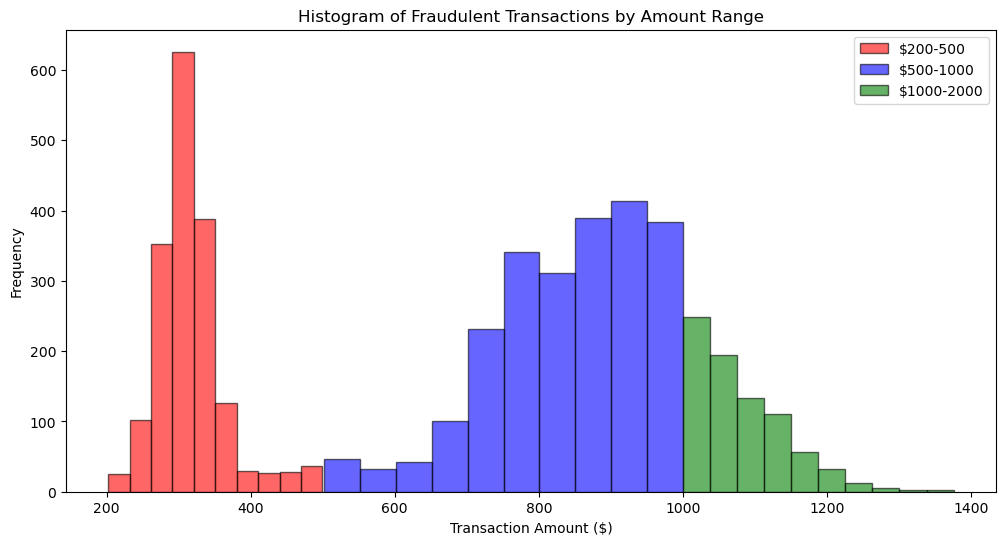

In [14]:
# Filter transactions within the specific ranges from cc_df
fraud_200_500 = cc_df[(cc_df['amt'] >= 200) & (cc_df['amt'] < 500) & (cc_df['is_fraud'] == 1)]
fraud_500_1000 = cc_df[(cc_df['amt'] >= 500) & (cc_df['amt'] < 1000) & (cc_df['is_fraud'] == 1)]
fraud_1000_2000 = cc_df[(cc_df['amt'] >= 1000) & (cc_df['amt'] < 2000) & (cc_df['is_fraud'] == 1)]

# Plotting
plt.figure(figsize=(12, 6))

# Histogram for fraudulent transactions within $200-$500 range
plt.hist(fraud_200_500['amt'], bins=10, color='red', alpha=0.6, label='$200-500', edgecolor='black')

# Histogram for fraudulent transactions within $500-$1000 range
plt.hist(fraud_500_1000['amt'], bins=10, color='blue', alpha=0.6, label='$500-1000', edgecolor='black')

# Histogram for fraudulent transactions within $1000-$2000 range
plt.hist(fraud_1000_2000['amt'], bins=10, color='green', alpha=0.6, label='$1000-2000', edgecolor='black')

plt.title('Histogram of Fraudulent Transactions by Amount Range')
plt.xlabel('Transaction Amount ($)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


### Timestamp

When the fraudulent transactions occur could contain valuable information for the models. As such, lets expand out the timestamp to provide more information. 

In [15]:
# Expand the timestamp column
cc_df['hour'] = cc_df['timestamp'].dt.hour
cc_df['day_of_week'] = cc_df['timestamp'].dt.dayofweek
cc_df['month'] = cc_df['timestamp'].dt.month
cc_df['is_weekend'] = cc_df['timestamp'].dt.dayofweek >= 5

# Create time of day categories
def categorize_time_of_day(hour):
    if 0 <= hour < 6:
        return 'night'
    elif 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    else:
        return 'evening'

cc_df['time_of_day'] = cc_df['hour'].apply(categorize_time_of_day)

# Drop the original timestamp if not needed
cc_df.drop(columns=['timestamp'], inplace=True)

### Customer and Merchant Longitude and Latitude

In [16]:
# Calculate distance feature
def calculate_distance(row):
    transaction_location = (row['lat'], row['long'])
    merchant_location = (row['merch_lat'], row['merch_long'])
    return great_circle(transaction_location, merchant_location).miles

# Apply distance calculation
cc_df['distance_to_merchant'] = cc_df.apply(calculate_distance, axis=1)

# Drop the individual location columns
cc_df.drop(columns=['lat', 'long', 'merch_lat', 'merch_long'], inplace=True)

While this column provides great information, it is not feasible to assume that in the real world we will have access to both the latitude and longitude coordinates of both the customer and the merchant. As such, we will drop this column.

In [17]:
# Drop the column
cc_df.drop(columns=['distance_to_merchant'], inplace=True)

## Categorical Columns

### Customer Count 

In [18]:
print(f"There are {cc_df['cc_num'].nunique()} unique customers in the dataset.")

There are 980 unique customers in the dataset.


### Merchant

In [19]:
cc_df['merchant'].value_counts()

merchant
fraud_Kilback LLC         159
fraud_Boyer PLC           144
fraud_Cormier LLC         142
fraud_Kuhn LLC            123
fraud_Schumm PLC          116
                         ... 
fraud_Johnston-Casper      19
fraud_Treutel-King         18
fraud_Smitham-Schiller     18
fraud_Bednar Inc           17
fraud_Kris-Kertzmann       14
Name: count, Length: 693, dtype: int64

It appears that all of the entires begin with 'fraud_'. If they do, lets remove the extraneous wording. 

In [20]:
# Investigate the column
all_fraud = cc_df['merchant'].str.startswith('fraud_').all()
print(f"Do all merchants start with 'fraud_'? {all_fraud}")

# Remove the text at the beginning of each entry
cc_df['merchant'] = cc_df['merchant'].str.replace('^fraud_', '', regex=True)

# Check work
cc_df['merchant'].value_counts()

Do all merchants start with 'fraud_'? True


merchant
Kilback LLC         159
Boyer PLC           144
Cormier LLC         142
Kuhn LLC            123
Schumm PLC          116
                   ... 
Johnston-Casper      19
Treutel-King         18
Smitham-Schiller     18
Bednar Inc           17
Kris-Kertzmann       14
Name: count, Length: 693, dtype: int64

Given the high cardinality of the column and that there is a category column that labels the transaction in a more conventional sense, the merchant column will be dropped. 

If the models performance does not reach an adequate level, the inclusion of this column will be revisted. 

In [21]:
# Drop column
cc_df.drop(['merchant'], axis=1, inplace=True)

### Category

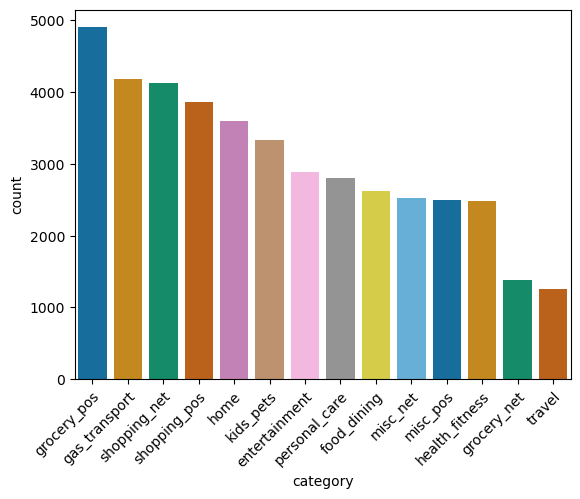

In [22]:
# Create category counts
category_value_counts = cc_df['category'].value_counts()

# Convert the Series to a DataFrame for easier plotting
category_df = category_value_counts.reset_index()
category_df.columns = ['category', 'count']

# Plot
sns.barplot(x='category', y='count', data=category_df, hue='category', palette=sns.color_palette("colorblind"))
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

### Gender

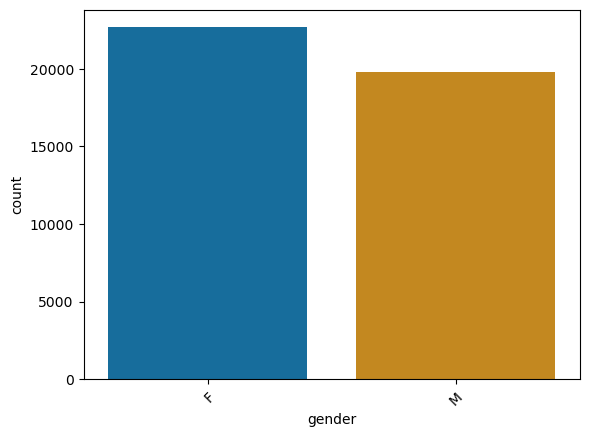

In [23]:
# Create category counts
gender_value_counts = cc_df['gender'].value_counts()

# Convert the Series to a DataFrame for easier plotting
category_df = gender_value_counts.reset_index()
category_df.columns = ['gender', 'count']

# Plot
sns.barplot(x='gender', y='count', data=category_df, hue='gender', palette=sns.color_palette("colorblind"))
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

### Job

In [24]:
# Covert the rows to lowercase and remove whitespace
cc_df['job'] = cc_df['job'].str.lower().str.strip()

In [25]:
# Define a mapping for collapsing job titles with unique titles
job_mapping = {
    # Engineering and Technology
    'engineering and technology': [
        'engineer', 'technical', 'aeronautical engineer', 'biomedical engineer', 'engineering geologist',
        'environmental engineer', 'it consultant', 'multimedia programmer', 'programmer', 'technology',
        'electronics engineer', 'naval architect', 'materials engineer', 'mining engineer', 'mechanical engineer',
        'chemical engineer', 'energy engineer', 'electrical engineer', 'drilling engineer', 'production engineer',
        'engineer, broadcasting (operations)', 'maintenance engineer', 'structural engineer', 'water engineer',
        'petroleum engineer', 'hydrologist', 'systems analyst', 'manufacturing systems engineer', 'building services engineer',
        'civil engineer, contracting', 'communications engineer', 'engineer, automotive', 'engineer, control and instrumentation',
        'physiotherapist', 'engineer, production', 'engineer, biomedical', 'engineer, mining', 'technical brewer', 
        'manufacturing engineer', 'engineer, electronics', 'engineer, petroleum', 'engineer, agricultural', 'engineer, land',
        'engineer, aeronautical', 'engineer, civil (contracting)', 'control and instrumentation engineer', 'network engineer',
        'broadcast engineer', 'data scientist', 'applications developer', 'programmer, multimedia', 'programmer, applications',
        'technical sales engineer', 'telecommunications researcher', 'industrial/product designer', 'seismic interpreter',
        'environmental health practitioner', 'software engineer', 'site engineer', 'make', 'metallurgist',
        'product/process development scientist', 'engineer, technical sales', 'engineer, communications', 'designer, multimedia',
        'garment/textile technologist', 'mudlogger', 'pilot, airline', 'contractor', 'energy manager', 'database administrator',
        'geophysicist/field seismologist', 'armed forces logistics/support/administrative officer', 'intelligence analyst',
        'architectural technologist', 'design engineer', 'armed forces technical officer', 'contracting civil engineer',
    ],
    
    # Medical and Healthcare
    'medical and healthcare': [
        'medical professional', 'psychologist', 'psychotherapist', 'psychotherapist, child', 'psychologist, clinical',
        'psychiatrist', 'radiographer, diagnostic', 'radiographer, therapeutic', 'physiological scientist', 'health physicist',
        'medical physicist', 'occupational therapist', 'counsellor', 'therapist', 'nutritionist', 'pharmacologist', 'paramedic',
        'pathologist', 'immunologist', 'podiatrist', 'chiropodist', 'dance movement psychotherapist', 'hospital doctor',
        'scientist, audiological', 'toxicologist', 'private music teacher', 'forensic psychologist', 'child psychotherapist',
        'learning disability nurse', 'dispensing optician', 'health and safety adviser', 'mental health nurse', 'phytotherapist',
        'biomedical scientist', 'community pharmacist', 'nutritional therapist', 'clinical research associate', 'clinical biochemist',
        'osteopath', 'orthoptist', 'medical technical officer', 'veterinary surgeon', 'psychologist, forensic', 'surgeon',
        'exercise physiologist', 'occupational psychologist', 'medical sales representative', 'cytogeneticist', 'occupational hygienist',
        'counselling psychologist', 'psychologist, counselling', 'fisheries officer', 'physiotherapist', 'psychologist, sport and exercise',
        'pharmacist, community', 'psychiatric nurse', 'doctor, general practice', 'nurse, children\'s', 'paediatric nurse',
        'therapist, occupational', 'medical secretary', 'diagnostic radiographer', 'therapist, sports', 'therapist, drama',
        'therapist, horticultural', 'therapist, music', 'oncologist', 'embryologist, clinical', 'neurosurgeon', 'pharmacist, hospital',
        'optometrist', 'health visitor', 'clinical psychologist', 'herbalist', 'acupuncturist', 'homeopath', 'animal nutritionist',
        'general practice doctor', 'doctor, hospital', 'hospital pharmacist', 'nurse, mental health', 'therapist, art',
        'health promotion specialist', 'counselling psychologist', 'clinical psychologist', 'animal technologist',
        'horticultural therapist', 'sport and exercise psychologist', 'ambulance person',
    ],
    
    # Education and Research
    'education and research': [
        'teacher', 'lecturer', 'research scientist', 'academic librarian', 'educator', 'education officer', 
        'training and development officer', 'higher education careers adviser', 'secondary school teacher', 'early years teacher',
        'further education lecturer', 'learning mentor', 'science writer', 'outdoor activities/education manager',
        'archaeologist', 'assistant professor', 'professor emeritus', 'conservator, museum/gallery', 'museum/gallery exhibitions officer',
        'librarian, academic', 'teacher, special educational needs', 'education officer, museum', 'research scientist (physical sciences)',
        'education officer, community', 'research officer, trade union', 'research officer, political party', 'museum education officer',
        'educational psychologist', 'associate professor', 'tefl teacher', 'english as a second language teacher',
        'english as a foreign language teacher', 'private music teacher', 'sub', 'librarian, public', 'special educational needs teacher',
        'teacher, early years/pre', 'teacher, secondary school', 'teacher, english as a foreign language', 'lecturer, higher education',
        'education administrator', 'teaching laboratory technician', 'community education officer', 'primary school teacher',
        'teacher, adult education', 'researcher', 'curriculum developer', 'higher education administrator', 'program evaluator',
        'academic advisor', 'education policy analyst', 'training and development manager', 'instructional designer',
        'careers information officer', 'programme researcher, broadcasting/film/video', 'field trials officer',
        'armed forces training and education officer', 'administrator, education', 'special educational needs teacher',
        'social researcher', 'lexicographer', 'herpetologist', 'archivist', 'careers adviser', 'interpreter'
    ],
    
    # Arts, Media, and Design
    'arts, media, and design': [
        'designer', 'artist', 'media planner', 'advertising account planner', 'copywriter, advertising', 'journalist',
        'film/video editor', 'radio producer', 'television/film/video producer', 'music tutor', 'art therapist',
        'designer, television/film set', 'print designer', 'multimedia artist', 'exhibition designer', 'magazine features editor',
        'clothing/textile technologist', 'musician', 'producer, television/film/video', 'photographer', 'video editor',
        'stage manager', 'producer, radio', 'radio broadcast assistant', 'television production assistant', 'press photographer',
        'broadcast presenter', 'camera operator', 'set designer', 'theatre manager', 'theatre director', 'curator',
        'press photographer', 'television floor manager', 'exhibitions officer, museum/gallery', 'editor, commissioning',
        'editor, film/video', 'production assistant, radio', 'media buyer', 'music therapist', 'interior and spatial designer',
        'textile designer', 'glass blower/designer', 'arts development officer', 'community arts worker', 'designer, ceramics/pottery',
        'fine artist', 'designer, industrial/product', 'designer, exhibition/display', 'designer, jewellery', 'copy',
        'designer, furniture', 'designer, interior/spatial', 'animator', 'illustrator', 'special effects artist',
        'art gallery manager', 'visual merchandiser', 'gaffer', 'colour technologist', 'bookseller', 'magazine journalist',
        'editor, magazine features', 'programmer, multimedia', 'product designer', 'fashion designer', 'jewellery designer',
        'environmental education officer', 'writer', 'ceramics designer', 'architect', 'presenter, broadcasting',
        'conservator, furniture', 'broadcast journalist',
    ],
    
    # Business and Management
    'business and management': [
        'chief executive officer', 'chief financial officer', 'chief operating officer', 'chief technology officer',
        'chief strategy officer', 'manager', 'business consultant', 'management consultant', 'sales professional',
        'marketing', 'public relations', 'human resources officer', 'operations manager', 'executive', 'facilities manager',
        'purchasing manager', 'product manager', 'chief marketing officer', 'call centre manager', 'buyer, industrial',
        'consulting and advisory', 'production manager', 'sales executive', 'sales professional, it', 'health service manager',
        'systems developer', 'it trainer', 'business analyst', 'public relations account executive', 'retail merchandiser',
        'retail manager', 'logistics and distribution manager', 'charity fundraiser', 'human resources consultant',
        'commercial manager', 'marketing executive', 'sales promotion account executive', 'business development manager',
        'project manager', 'account manager', 'hr manager', 'business owner', 'management accountant', 'financial planner',
        'investment banker', 'investment analyst', 'accountant', 'credit controller', 'mortgage adviser', 'treasury analyst',
        'real estate agent', 'stockbroker', 'business adviser', 'company director', 'trading standards officer', 'mortgage broker',
        'business manager', 'public affairs consultant', 'external auditor', 'tax adviser', 'accounting technician',
        'non-profit manager', 'campaign manager', 'marketing manager', 'accountancy manager', 'management analyst',
        'strategic planner', 'business development executive', 'director, corporate affairs', 'director, marketing',
        'business intelligence analyst', 'business operations manager', 'commercial director', 'communications manager',
        'director of operations', 'financial analyst', 'insurance underwriter', 'management consultant',
        'financial adviser', 'chartered public finance accountant', 'quantity surveyor', 'surveyor, land/geomatics',
        'prison officer', 'pensions consultant', 'comptroller', 'land/geomatics surveyor', 'race relations officer',
        'financial trader', 'building surveyor', 'scientist, research (maths)', 'scientist, marine', 'claims inspector/assessor',
        'scientist, biomedical', 'senior tax professional/tax inspector', 'dealer', 'development worker, community',
        'operations geologist', 'barrister\'s clerk', 'geoscientist', 'lecturer, further education', 'historic buildings inspector/conservation officer',
        'chartered loss adjuster', 'travel agency manager', 'commercial/residential surveyor', 'tree surgeon', 'futures trader',
        'development worker, international aid', 'tax inspector', 'journalist, newspaper', 'heritage manager', 'press sub',
        'fitness centre manager', 'amenity horticulturist', 'administrator', 'equality and diversity officer', 'physicist, medical',
        'commercial horticulturist', 'insurance risk surveyor', 'advice worker', 'building control surveyor', 'risk analyst',
        'wellsite geologist', 'tourist information centre manager', 'leisure centre manager', 'politician\'s assistant',
        'waste management officer', 'secretary/administrator', 'administrator, local government', 'trade mark attorney',
        'investment banker, corporate', 'arboriculturist', 'museum/gallery conservator', 'statistician', 'surveyor, minerals',
        'geologist, wellsite', 'optician, dispensing', 'administrator, charities/voluntary organisations', 'furniture designer',
        'sports development officer', 'patent attorney', 'market researcher', 'farm manager', 'research scientist (life sciences)',
        'operational researcher', 'land', 'warden/ranger', 'regulatory affairs officer', 'aid worker', 'landscape architect',
        'web designer', 'insurance broker', 'accountant, chartered public finance', 'pension scheme manager', 'research scientist (maths)',
        'surveyor, rural practice', 'surveyor, mining', 'theme park manager', 'retail banker', 'scientist, research (physical sciences)',
        'conservation officer, historic buildings', 'equities trader', 'emergency planning/management officer', 'field seismologist',
        'corporate investment banker', 'geologist, engineering', 'licensed conveyancer', 'cartographer', 'scientist, physiological',
        'records manager', 'rural practice surveyor', 'planning and development surveyor', 'chartered accountant', 'quarry manager',
        'town planner', 'horticulturist, commercial', 'insurance claims handler', 'advertising copywriter', 'volunteer coordinator',
        'furniture conservator/restorer', 'public house manager', 'sports administrator', 'civil service fast streamer', 'designer, textile',
        'event organiser', 'community development worker', 'hydrographic surveyor', 'commissioning editor', 'air broker', 'cabin crew',
        'engineer, drilling', 'engineer, building services', 'biochemist, clinical', 'economist', 'engineer, maintenance',
        'plant breeder/geneticist', 'chartered legal executive (england and wales)', 'chief of staff', 'information systems manager',
        'engineer, manufacturing', 'scientist, clinical (histocompatibility and immunogenetics)', 'social research officer, government',
        'minerals surveyor', 'scientist, research (medical)', 'research scientist (medical)', 'analytical chemist', 'clinical cytogeneticist',
        'chemist, analytical', 'loss adjuster, chartered', 'teacher, primary school', 'production assistant, television',
        'horticultural consultant', 'engineer, materials', 'air cabin crew', 'investment banker, operational',
        'civil service administrator', 'solicitor, scotland', 'public librarian', 'restaurant manager, fast food',
        'geneticist, molecular', 'estate manager/land agent', 'water quality scientist', 'surveyor, hydrographic', 'dancer',
        'television camera operator', 'accountant, chartered certified', 'tour manager', 'nature conservation officer',
        'personnel officer', 'administrator, arts', 'local government officer', 'engineer, structural', 'buyer, retail',
        'engineer, site', 'location manager', 'information officer', 'merchandiser, retail', 'industrial buyer', 'ship broker',
        'forest/woodland manager', 'accountant, chartered', 'retail buyer', 'advertising account executive', 'barista', 
        'company secretary', 'hotel manager', 'catering manager'
    ],
    
    # Law and Public Service
    'law and public service': [
        'lawyer', 'solicitor', 'barrister', 'legal executive', 'paralegal', 'legal secretary', 'notary public',
        'probate practitioner', 'conveyancer', 'legal adviser', 'police officer', 'firefighter', 'paramedic', 'social worker',
        'probation officer', 'criminologist', 'community support worker', 'coroner', 'legal advisor', 'court usher', 'diplomat',
        'human rights officer', 'immigration officer', 'military officer', 'intelligence officer', 'government administrator',
        'policy analyst', 'legal consultant', 'legal researcher', 'environmental health officer', 'charity officer',
        'emergency planning officer', 'armed forces', 'political researcher', 'researcher, policy', 'public affairs officer',
        'advocate', 'community safety officer', 'law enforcement officer', 'social services manager', 'public services manager',
        'community worker', 'legal compliance officer', 'adviser, business', 'investigator', 'public relations officer',
        'tax adviser', 'trade union representative', 'public policy consultant', 'caseworker', 'data protection officer',
        'civil service', 'foreign service officer', 'human resources officer', 'court clerk', 'legislative assistant',
        'nonprofit administrator', 'social care worker', 'public health inspector', 'social researcher', 'court interpreter',
        'social welfare officer', 'regulatory affairs specialist', 'senior policy advisor', 'legal assistant', 'tax consultant',
        'legal analyst', 'compliance officer', 'charity fundraiser', 'victim support officer', 'police investigator',
        'court reporter', 'forensic accountant', 'legal administrator', 'legal officer', 'compliance manager', 'community organizer',
        'political adviser', 'social justice advocate', 'human resources manager', 'regulatory officer'
    ],
    
    # Science and Environment
    'science and environment': [
        'scientist', 'environmental scientist', 'biologist', 'ecologist', 'geologist', 'chemist', 'physicist', 'climatologist',
        'meteorologist', 'marine biologist', 'zoologist', 'environmental consultant', 'conservationist', 'research scientist',
        'environmental engineer', 'wildlife biologist', 'forensic scientist', 'hydrologist', 'astrobiologist', 'geochemist',
        'oceanographer', 'environmental educator', 'biochemist', 'environmental policy analyst', 'environmental health specialist',
        'environmental protection officer', 'environmental compliance specialist', 'earth scientist', 'toxicologist',
        'forensic ecologist', 'environmental risk assessor', 'environmental manager', 'science communicator', 'nature reserve manager',
        'agronomist', 'environmental researcher', 'sustainable development consultant', 'geophysicist', 'scientific researcher',
        'agriculture consultant', 'forestry officer', 'environmental analyst', 'climate scientist', 'wildlife conservationist',
        'environmental microbiologist', 'environmental geologist', 'renewable energy consultant', 'agricultural scientist',
        'environmental technician', 'sustainable energy specialist', 'science educator', 'aquatic biologist', 'applied scientist',
        'soil scientist', 'biodiversity officer', 'scientific advisor', 'scientific policy advisor', 'research and development scientist',
        'field biologist', 'geotechnical engineer', 'climate change analyst', 'sustainability consultant', 'environmental field officer',
        'natural resource manager', 'biological technician', 'environmental health scientist', 'energy auditor', 'environmental compliance officer',
        'marine scientist', 'conservation scientist', 'environmental assessment specialist', 'hydrogeologist', 'scientific laboratory technician',
        'urban planner', 'conservation biologist', 'waste management specialist', 'audiological scientist', 'operations geologist',
    ],
    
    # Transportation and Logistics
    'transportation and logistics': [
        'logistics manager', 'transport planner', 'supply chain manager', 'transportation coordinator', 'freight forwarder',
        'shipment coordinator', 'distribution manager', 'traffic engineer', 'warehouse manager', 'delivery driver',
        'logistics coordinator', 'transport operator', 'road transport manager', 'air cargo agent', 'sea freight coordinator',
        'logistics analyst', 'import/export coordinator', 'fleet manager', 'route planner', 'transport manager', 'cargo handler',
        'supply chain analyst', 'shipping manager', 'inventory manager', 'logistics consultant', 'transportation specialist',
        'logistics director', 'supply chain director', 'transportation analyst', 'transport operations manager', 'logistics technician',
        'transportation planner', 'transportation manager', 'logistics support officer', 'warehouse operative', 'transit coordinator',
        'shipping coordinator', 'distribution coordinator', 'supply chain consultant', 'traffic manager', 'freight manager',
        'airline operations manager', 'railway manager', 'logistics project manager', 'warehouse supervisor', 'transit planner',
        'import/export manager', 'logistics executive', 'supply chain executive', 'fleet coordinator', 'transportation coordinator',
        'traffic coordinator', 'road transport coordinator', 'port operations manager', 'sea cargo agent', 'air freight manager',
        'transportation operations coordinator', 'rail transport manager', 'distribution executive', 'transportation supervisor', 
        'tourism officer', 'airline pilot', 'air traffic controller', 
    ],
    
    # Agriculture and Rural Affairs
    'agriculture and rural affairs': [
        'farmer', 'agricultural consultant', 'farm manager', 'agricultural engineer', 'agronomist', 'landscaper', 'horticulturalist',
        'forester', 'land agent', 'agriculture adviser', 'veterinary surgeon', 'animal husbandry', 'plant breeder', 'soil scientist',
        'rural surveyor', 'veterinary technician', 'crop scientist', 'animal nutritionist', 'organic farmer', 'agricultural scientist',
        'environmental scientist', 'rural development officer', 'poultry farmer', 'dairy farmer', 'crop consultant', 'landscape architect',
        'agriculture technician', 'rural affairs consultant', 'fisheries officer', 'forestry consultant', 'land management officer',
        'arborist', 'agricultural project manager', 'rural planner', 'horticulture manager', 'animal care technician', 'plant pathologist',
        'livestock manager', 'sustainable agriculture consultant', 'pest control advisor', 'land use planner', 'organic agriculture consultant',
        'rural support officer', 'farm worker', 'agricultural educator', 'sustainable land manager', 'aquaculture manager',
        'soil conservationist', 'agriculture policy advisor', 'organic horticulturist', 'plant scientist', 'livestock advisor',
        'animal behaviorist', 'rural business manager', 'farm consultant', 'agriculture researcher', 'plant protection advisor',
    ],
    
    # Construction and Architecture
    'construction and architecture': [
        'architect', 'construction manager', 'building surveyor', 'quantity surveyor', 'civil engineer', 'site manager',
        'project manager', 'structural engineer', 'quantity surveyor', 'building services engineer', 'architectural technician',
        'urban planner', 'interior designer', 'landscape architect', 'contractor', 'construction estimator', 'construction project manager',
        'building inspector', 'construction engineer', 'design engineer', 'site engineer', 'construction consultant', 'architectural designer',
        'building control officer', 'surveyor', 'project architect', 'construction supervisor', 'project coordinator', 'draftsman',
        'structural draughtsperson', 'landscaping contractor', 'architectural assistant', 'urban designer', 'construction technician',
        'design and build manager', 'facilities manager', 'building conservationist', 'site supervisor', 'property manager',
        'construction director', 'building manager', 'architectural technologist', 'land surveyor', 'building project manager',
        'interior architect', 'development manager', 'residential surveyor', 'commercial surveyor', 'architectural project manager',
        'construction consultant', 'project estimator', 'architectural project coordinator', 'building surveyor', 'commercial property manager',
        'construction design manager', 'site coordinator', 'civil engineering technician', 'structural project manager', 'quantity surveyor',
    ]
}

# Function to map old job titles to new categories
def collapse_jobs(job_title):
    for category, titles in job_mapping.items():
        if job_title in titles:
            return category
    return job_title  # Return the original title if no match is found

# Apply the function to the 'job' column
cc_df['job'] = cc_df['job'].apply(collapse_jobs)

# Confirm actions have condensed the column rows
cc_df['job'].value_counts()

job
business and management          15865
medical and healthcare            7531
engineering and technology        6809
arts, media, and design           6048
education and research            4023
science and environment            905
law and public service             759
transportation and logistics       288
agriculture and rural affairs      236
Name: count, dtype: int64

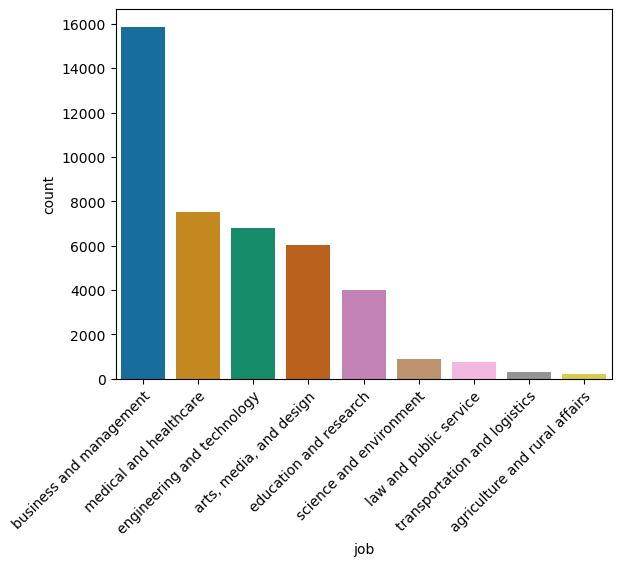

In [26]:
# Create category counts
job_value_counts = cc_df['job'].value_counts().head(20)

# Convert the Series to a DataFrame for easier plotting
category_df = job_value_counts.reset_index()
category_df.columns = ['job', 'count']

# Plot
sns.barplot(x='job', y='count', data=category_df, hue='job', palette=sns.color_palette("colorblind"))
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

### DOB

It would be nice if we were able to see the age of the user as well as what generation they belong in. Seeing this could help to see if there are different spending habits amongst the users. 

In [27]:
# Calculate age
cc_df['age'] = datetime.now().year - cc_df['dob'].dt.year

In [28]:
# Create a function to define age groups
def age_group(age):
    if age < 10:
        return 'Gen Alpha'
    elif age < 26:
        return 'Gen Z'
    elif age < 42:
        return 'Millennial'
    elif age < 58:
        return 'Gen X'
    elif age < 77:
        return 'Baby Boomer'
    else:
        return 'Silent Generation'

# Apply the function
cc_df['age_group'] = cc_df['age'].apply(age_group)

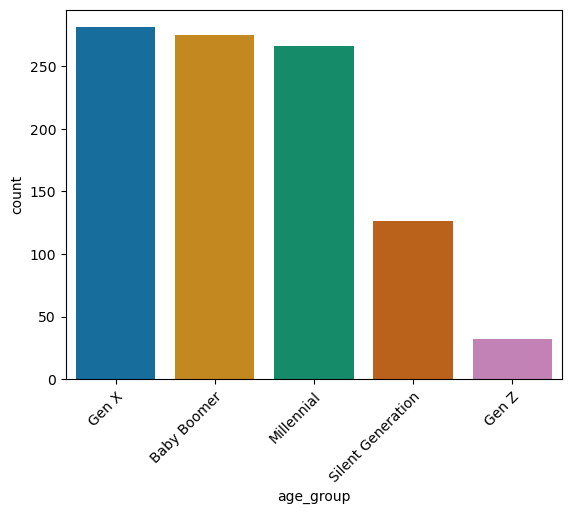

In [29]:
# Aggregate data by cc_num to get unique users
unique_users = cc_df.drop_duplicates(subset=['cc_num'])

# Create category counts based on unique users
age_group_value_counts = unique_users['age_group'].value_counts()

# Convert the Series to a DataFrame for easier plotting
category_df = age_group_value_counts.reset_index()
category_df.columns = ['age_group', 'count']

# Plot
sns.barplot(x='age_group', y='count', data=category_df, hue='age_group', palette=sns.color_palette("colorblind"))
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

## MultiColinearity Checks

Inside of the dataset, there are multiple columns that are duplicates of each other. Including all of the features will lead to multicolinearity and as such, this needs to be addressed. 

Duplicate columns:
- locations (customer and merchant)
    - street, city, zip
- age
    - dob, age, age_group

Additionally, there are columns that will not provide useful information to the models. 

- customer name
    - first, last
- transaction number

Lets determine how correlated the features are to each other. 

### Numeric Columns

In [30]:
# List of numerical columns
numeric_features = [
    'amt', 
    'city_pop', 
    'age', 
    'hour', 
    'day_of_week', 
    'month'
]

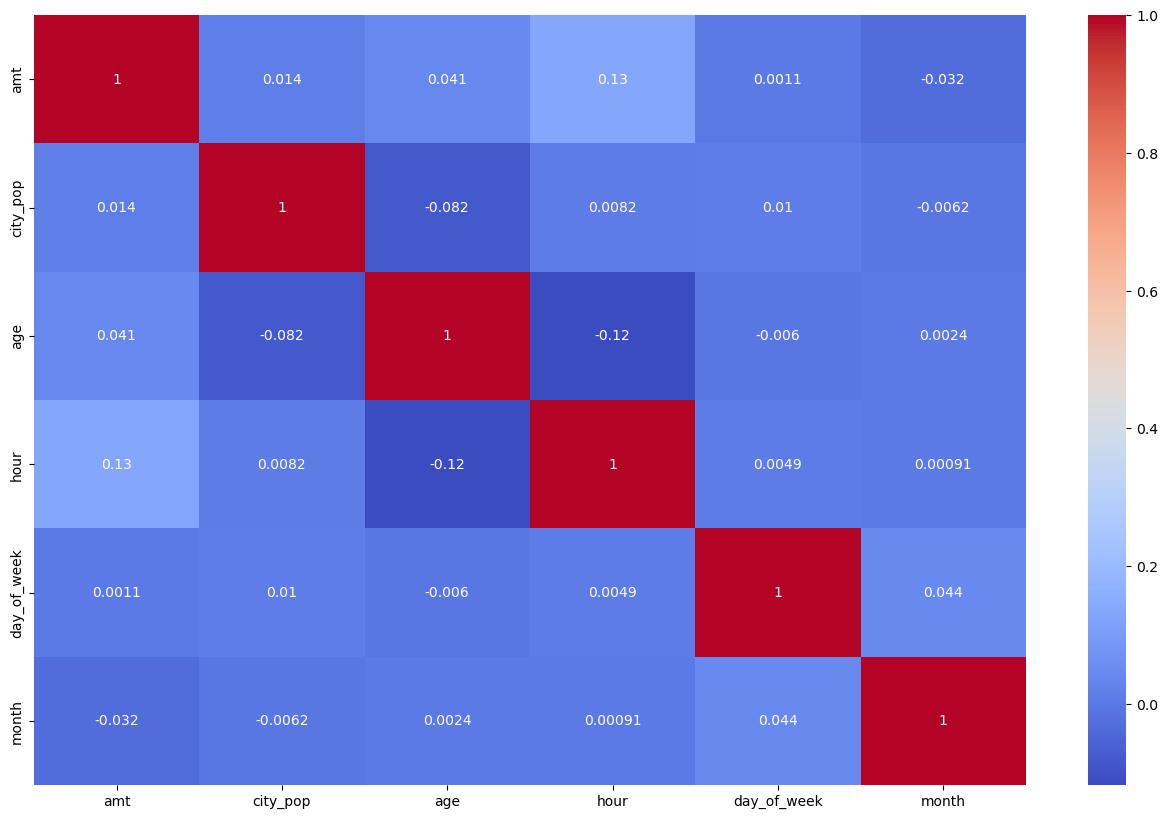

In [31]:
# Calculate correlation matrix
corr_matrix = cc_df[numeric_features].corr()

# Plot heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

### Categorical Columns

In [32]:
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42464 entries, 0 to 49999
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   cc_num              42464 non-null  object        
 1   category            42464 non-null  object        
 2   amt                 42464 non-null  float64       
 3   first               42464 non-null  object        
 4   last                42464 non-null  object        
 5   gender              42464 non-null  object        
 6   street              42464 non-null  object        
 7   city                42464 non-null  object        
 8   state               42464 non-null  object        
 9   zip                 42464 non-null  int64         
 10  city_pop            42464 non-null  int64         
 11  job                 42464 non-null  object        
 12  dob                 42464 non-null  datetime64[ns]
 13  trans_num           42464 non-null  object        


In [33]:
# List of categorical columns to be converted
categorical_columns = ['category', 'gender', 'job', 'time_of_day', 'age_group']

# Create dummy variables
cc_df_dummies = pd.get_dummies(cc_df[categorical_columns], drop_first=True)

In [34]:
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['feature'] = cc_df_dummies.columns
vif_data['VIF'] = [variance_inflation_factor(cc_df_dummies.values, i) for i in range(cc_df_dummies.shape[1])]

# Filter features with VIF greater than 5
high_vif_features = vif_data[vif_data['VIF'] > 5]

# Print results
if not high_vif_features.empty:
    print("Features with VIF greater than 5:")
    print(high_vif_features)
else:
    print("No multicollinearity detected (all VIFs are less than 5).")

No multicollinearity detected (all VIFs are less than 5).


# Baseline Models

## Define the Features 

Inside of the DataFrame, there are still columns that have high cardinality or that do not provide good information to the model. 

Lets clean up the DataFrame. 

In [35]:
model_df = cc_df.copy()

In [36]:
model_df.drop(
    [
        'cc_num', 
        'first', 
        'last', 
        'street', 
        'city', 
        'zip', 
        'dob', 
        'amt_range',
        'expanded_amt_range',
        'trans_num', 
        'merch_zipcode', 
        'time_of_day', 
        'is_weekend'
    ], axis=1 , inplace=True
)

In [37]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42464 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   category     42464 non-null  object 
 1   amt          42464 non-null  float64
 2   gender       42464 non-null  object 
 3   state        42464 non-null  object 
 4   city_pop     42464 non-null  int64  
 5   job          42464 non-null  object 
 6   is_fraud     42464 non-null  int64  
 7   hour         42464 non-null  int32  
 8   day_of_week  42464 non-null  int32  
 9   month        42464 non-null  int32  
 10  age          42464 non-null  int32  
 11  age_group    42464 non-null  object 
dtypes: float64(1), int32(4), int64(2), object(5)
memory usage: 3.6+ MB


In [38]:
X = model_df.drop(['is_fraud'],axis=1)
y = model_df['is_fraud']

In [39]:
X.head()

,category,amt,gender,state,city_pop,job,hour,day_of_week,month,age,age_group
0,home,77.90,M,OK,1078,medical and healthcare,12,2,6,35,Millennial
1,health_fitness,47.78,M,MI,134056,medical and healthcare,19,5,4,44,Gen X
2,misc_net,690.81,M,NC,238602,business and management,22,0,1,31,Millennial
3,gas_transport,65.85,M,OK,640470,business and management,9,4,8,58,Baby Boomer
4,shopping_net,67.11,M,OH,267,business and management,16,0,1,19,Gen Z


In [40]:
sampling_techniques = {
    'oversample': RandomOverSampler(random_state=19),
    'smote': SMOTE(random_state=19),
    'borderline_smote': BorderlineSMOTE(random_state=19),
    'kmeans_smote': KMeansSMOTE(random_state=19),
    'adasyn': ADASYN(random_state=19),
    'smote_tomek': SMOTETomek(random_state=19),
    'smote_enn': SMOTEENN(random_state=19)
}

## Baseline Logistic Regression

In [89]:
# Instantiate the model
baseline_model = LogisticRegression(max_iter=1500, random_state=19)

In [90]:
# Define a function to preprocess the data
def get_preprocessor(X):
    numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    return ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_features)
        ]
    )

In [91]:
# Split the data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=19)

In [95]:
# Store results in a DataFrame
results = []

for name, sampler in sampling_techniques.items():
    # Create a pipeline with preprocessing and the resampler
    pipeline = ImbPipeline(steps=[
        ('preprocessor', get_preprocessor(X_train)),
        ('resampler', sampler),
        ('classifier', baseline_model)
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Predict on train and test sets
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    # Calculate PR-AUC scores
    y_train_pred_proba = pipeline.predict_proba(X_train)[:, 1]
    train_prauc = average_precision_score(y_train, y_train_pred_proba)
    train_f1 = f1_score(y_train, pipeline.predict(X_train))

    # Calculate test PR-AUC score
    y_test_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    test_prauc = average_precision_score(y_test, y_test_pred_proba)
    test_f1 = f1_score(y_test, pipeline.predict(X_test))
    
    # Store results
    results.append({
        'model_name': 'BaselineLogisticRegression',
        'sampling_technique': name,
        'train_prauc_score': train_prauc,
        'test_prauc_score': test_prauc,
        'train_f1_score': train_f1,
        'test_f1_score': test_f1
    })

In [96]:
# Convert results to DataFrame
baseline_results = pd.DataFrame(results)

## Logistic Regression

In [41]:
log_reg_model = LogisticRegression(max_iter=1500, random_state=19)
log_reg_param_grid = [
    {'classifier__C': [0.1, 1], 'classifier__solver': ['liblinear'], 'classifier__penalty': ['l1', 'l2']},
    {'classifier__C': [0.1, 1], 'classifier__solver': ['lbfgs'], 'classifier__penalty': ['l2']},
    {'classifier__C': [0.1, 1], 'classifier__solver': ['saga'], 'classifier__penalty': ['l1', 'l2']}
]

In [42]:
# Initialize the ModelEvaluator class
log_reg_evaluator = ModelEvaluator(log_reg_model, log_reg_param_grid, X, y, sampling_techniques, random_state=19)

# Evaluate the model across all resampled datasets
log_reg_evaluator.evaluate()

# Store the results DataFrame
log_reg_results = log_reg_evaluator.eval_results_df

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


## Decision Tree

In [43]:
dt_model = DecisionTreeClassifier(random_state=19)
dt_param_grid = {
    'classifier__criterion': ['gini', 'entropy'],  
    'classifier__max_depth': [5, 10],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
}

In [44]:
# Initialize the ModelEvaluator class
dt_evaluator = ModelEvaluator(dt_model, dt_param_grid, X, y, sampling_techniques, random_state=19)

# Evaluate the model across all resampled datasets
dt_evaluator.evaluate()

# Store the results DataFrame
dt_results = dt_evaluator.eval_results_df

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits


## K-Nearest Neighbors 

In [45]:
# K-Nearest Neighbors model
knn_model = KNeighborsClassifier()

# Parameter grid for KNeighborsClassifier
knn_param_grid = {
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance'], 
    'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'classifier__p': [1, 2],
}

In [55]:
# Initialize the ModelEvaluator class
knn_evaluator = ModelEvaluator(knn_model, knn_param_grid, X, y, sampling_techniques, random_state=19)

# Evaluate the model across all resampled datasets
knn_evaluator.evaluate()

# Store the results DataFrame
knn_results = knn_evaluator.eval_results_df

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits


## Bagging Classifier

In [47]:
# Bagging Classifier model with a DecisionTreeClassifier as the base estimator
bagging_model = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=19), random_state=19)

# Parameter grid for BaggingClassifier
bagging_param_grid = {
    'classifier__n_estimators': [10, 50, 100],
    'classifier__max_samples': [0.5, 0.7, 1.0],
    'classifier__max_features': [0.5, 0.7, 1.0],
}

In [48]:
# Initialize the ModelEvaluator class
bagging_evaluator = ModelEvaluator(bagging_model, bagging_param_grid, X, y, sampling_techniques, random_state=19)

# Evaluate the model across all resampled datasets
bagging_evaluator.evaluate()

# Store the results DataFrame
bagging_results = bagging_evaluator.eval_results_df

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits


## Random Forest 

In [49]:
# Random Forest model
rf_model = RandomForestClassifier(random_state=19)

# Parameter grid for RandomForestClassifier
rf_param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
}

In [59]:
# Initialize the ModelEvaluator class
rf_evaluator = ModelEvaluator(rf_model, rf_param_grid, X, y, sampling_techniques, random_state=19)

# Evaluate the model across all resampled datasets
rf_evaluator.evaluate()

# Store the results DataFrame
rf_results = rf_evaluator.eval_results_df

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits


## Results

In [97]:
# List all results from model evaluations
all_results = [
    baseline_results,
    log_reg_results,
    dt_results,
    knn_results,
    bagging_results,
    rf_results
]

In [98]:
# List to hold DataFrames
dataframes_list = []

# Create results DataFrame
for result in all_results:
    dataframes_list.append(pd.DataFrame(result))

# Concatenate the DataFrames
results_df = pd.concat(dataframes_list, ignore_index=True)

results_df.sort_values(['test_prauc_score'], ascending=False)

,model_name,sampling_technique,train_prauc_score,test_prauc_score,train_f1_score,test_f1_score
39,RandomForestClassifier,adasyn,0.996153,0.971264,0.966763,0.917740
35,RandomForestClassifier,oversample,0.997561,0.971186,0.973092,0.915228
37,RandomForestClassifier,borderline_smote,0.993839,0.969430,0.957976,0.916822
32,BaggingClassifier,adasyn,0.999787,0.968728,0.992360,0.926082
29,BaggingClassifier,smote,0.999215,0.968094,0.978063,0.915418
30,BaggingClassifier,borderline_smote,0.999049,0.967625,0.976085,0.913087
36,RandomForestClassifier,smote,0.998813,0.967090,0.978214,0.916420
31,BaggingClassifier,kmeans_smote,0.998368,0.966797,0.970995,0.920626
28,BaggingClassifier,oversample,0.999982,0.966126,0.977178,0.911743
33,BaggingClassifier,smote_tomek,0.995300,0.964145,0.968937,0.917071


## Best Model Investigation

### Feature Importance of the Best Model

In [62]:
# Sort the stored DataFrame
sorted_feature_importances_df = rf_evaluator.feature_importances_df.sort_values(by='Importance', ascending=False)

# Display the top 20 features
sorted_feature_importances_df.head(20)

,Feature,Importance
0,amt,0.640672
3,category_gas_transport,0.036172
12,category_shopping_net,0.031204
5,category_grocery_pos,0.028918
1,city_pop,0.020534
7,category_home,0.018167
15,gender_M,0.015627
8,category_kids_pets,0.014528
2,category_food_dining,0.014226
9,category_misc_net,0.013680


Amount is by and far the most important feature to the model. Similar to the investigation we did earlier, this is due to the high concentration of fraudulent transactions that occur in between the amounts ranging from 200-2000.

### Thoughts on the Best Model

From the above models, we can see that the Random Forest model using the oversample resampling technique gave the best PR-AUC score. 

Given that the Random Forest model using the oversample resampling technique gave the best PR-AUC score, we will use this model going forward as we attempt to improve the PR-AUC score even more. 

# Boosting Models

## Gradient Boosting Classifier

In [75]:
# Instantiate the boosting model and parameter grid
gbm_model = GradientBoostingClassifier(random_state=19)

gbm_param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 4],
    'classifier__subsample': [0.8, 1.0]
}

In [76]:
# Boost the best model with hyperparameter tuning
rf_evaluator.boost_best_model(gbm_model, gbm_param_grid, 'adasyn')

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [77]:
# Store the results DataFrame
gbm_results = rf_evaluator.boosting_results_df

## Light GBM

In [78]:
# Instantiate the boosting model and parameter grid
lgb_model = LGBMClassifier(random_state=19)
lgb_param_grid = {
    'classifier__num_leaves': [31, 127],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__n_estimators': [100, 200]
}

In [79]:
# Boost the best model with hyperparameter tuning
rf_evaluator.boost_best_model(lgb_model, lgb_param_grid, 'adasyn')

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Info] Number of positive: 25343, number of negative: 25270
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14229
[LightGBM] [Info] Number of data points in the train set: 50613, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500721 -> initscore=0.002885
[LightGBM] [Info] Start training from score 0.002885


In [80]:
# Store the results DataFrame
lightgbm_results = rf_evaluator.boosting_results_df

## XGBoost

In [81]:
# Instantiate the boosting model and parameter grid
xgb_model = XGBClassifier(random_state=19)
xgb_param_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0]
}

In [82]:
# Boost the best model with hyperparameter tuning
rf_evaluator.boost_best_model(xgb_model, xgb_param_grid, 'adasyn')

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [83]:
# Store the results DataFrame
xgb_results = rf_evaluator.boosting_results_df

## Results

In [99]:
# List all results from model evaluations
boosted_results_df = pd.concat([gbm_results, lightgbm_results, xgb_results], ignore_index=True)

# Update column names
boosted_results_df.rename(columns={'train_average_precision_score': 'train_prauc_score', 'test_average_precision_score' : 'test_prauc_score'}, inplace=True)

boosted_results_df.sort_values(['test_prauc_score'], ascending=False)

,base_model,sampling_technique,boosting_model,train_prauc_score,test_prauc_score,train_f1_score,test_f1_score
1,RandomForestClassifier,adasyn,LGBMClassifier,1.000000,0.999435,0.999776,0.985703
2,RandomForestClassifier,adasyn,XGBClassifier,0.999266,0.998899,0.984433,0.979782
0,RandomForestClassifier,adasyn,GradientBoostingClassifier,0.992527,0.997055,0.943784,0.949737


**Model Score**

The best boosted model is the Light Gradient Boosted model which scored a 0.998599 test PR-AUC score. 

The PR-AUC evaluation metric highlights the model's:

- High Precision
    - The model achieves a high precision, meaning that when it predicts a transaction as fraudulent, it is very likely to be correct. This reduces the number of false positives—legitimate transactions that are incorrectly flagged as fraud.

- High Recall
    - The model also demonstrates high recall, meaning it correctly identifies a large proportion of actual fraudulent transactions. High recall ensures that as few fraudulent transactions as possible go undetected.
 

**Business Impact**

- Customer Experience
    - With high precision and recall, customers are less likely to be inconvenienced by false alarms, and genuine fraud attempts are more likely to be caught early, protecting customers from potential financial harm.

- Operational Efficiency
    - Fewer false positives mean that fewer resources need to be spent on investigating transactions that aren’t actually fraudulent. This allows fraud analysts to focus on the transactions that are most likely to be fraudulent.

- Risk Management
    - High recall ensures that the model captures the majority of fraudulent transactions, which is crucial for minimizing financial losses and maintaining trust with customers.

# Feature Minimization

Now that we know which model performs best, lets see what scores we can get when the feature space is decreased futher. If the model can perform at the same or relatively the same level with less complexity, we will use that model.

In [182]:
feature_min_X = X.drop(['city_pop', 'hour', 'gender'], axis=1)

In [349]:
feature_min_X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42464 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   category     42464 non-null  object 
 1   amt          42464 non-null  float64
 2   state        42464 non-null  object 
 3   job          42464 non-null  object 
 4   day_of_week  42464 non-null  int32  
 5   month        42464 non-null  int32  
 6   age          42464 non-null  int32  
 7   age_group    42464 non-null  object 
dtypes: float64(1), int32(3), object(4)
memory usage: 2.4+ MB


In [276]:
feature_min_sampling_technique = {
    'adasyn': ADASYN(random_state=19)
}

In [277]:
# Random Forest model
feat_min_rf_model = RandomForestClassifier(random_state=19)

# Parameter grid for RandomForestClassifier
feat_min_rf_param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
}

In [278]:
# Initialize the ModelEvaluator class
feat_min_rf_evaluator = ModelEvaluator(
    feat_min_rf_model, 
    feat_min_rf_param_grid, 
    feature_min_X, 
    y, 
    {'adasyn': ADASYN(random_state=19)}, 
    random_state=19
)

# Evaluate the model across all resampled datasets
feat_min_rf_evaluator.evaluate()

# Store the results DataFrame
feat_min_rf_results = feat_min_rf_evaluator.eval_results_df

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [279]:
# Display results
feat_min_rf_results

,model_name,sampling_technique,train_prauc_score,test_prauc_score,train_f1_score,test_f1_score
0,RandomForestClassifier,adasyn,0.989418,0.972605,0.935774,0.902574


In [280]:
# Instantiate the boosting model and parameter grid
feat_min_lgb_model = LGBMClassifier(random_state=19)
feat_min_lgb_param_grid = {
    'classifier__num_leaves': [31, 127],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__n_estimators': [100, 200]
}

In [281]:
# Boost the best model with hyperparameter tuning
feat_min_rf_evaluator.boost_best_model(feat_min_lgb_model, feat_min_lgb_param_grid, 'adasyn')

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Info] Number of positive: 25491, number of negative: 25270
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13769
[LightGBM] [Info] Number of data points in the train set: 50761, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502177 -> initscore=0.008708
[LightGBM] [Info] Start training from score 0.008708


In [282]:
# Store the results DataFrame
feat_min_lightgbm_results = feat_min_rf_evaluator.boosting_results_df

In [283]:
# Display results
feat_min_lightgbm_results

,base_model,sampling_technique,boosting_model,train_prauc_score,test_prauc_score,train_f1_score,test_f1_score
0,RandomForestClassifier,adasyn,LGBMClassifier,1.0,0.999224,0.999663,0.982538


Despite using fewer features, the model's performance remained consistent with that of the full dataset. Therefore, we've chosen this streamlined model for deployment.